In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

In [2]:
metrics = ['MRR','Hits@1','Hits@3']

In [10]:
def melt(df):
    error_metrics = [m + "_err" for m in metrics]

    # Melt the score columns
    df_scores = df[["Method", "Architecture"] + metrics].melt(
        id_vars=["Method", "Architecture"],
        var_name="Metric",
        value_name="Score"
    )

    # Melt the error columns
    df_errors = df[["Method", "Architecture"] + error_metrics].melt(
        id_vars=["Method", "Architecture"],
        var_name="Metric",
        value_name="Error"
    )

    # Fix the 'Metric' column in errors to match scores (remove '_err' suffix)
    df_errors["Metric"] = df_errors["Metric"].str.replace("_err", "", regex=False)

    # Merge scores and errors
    return pd.merge(df_scores, df_errors, on=["Method", "Architecture", "Metric"])

In [11]:
# First dataset (WN18RR)
df1 = pd.read_csv("kgc_wn18rr.csv")
df1_melted = melt(df1)

In [12]:
# Second dataset (FB15k-237)
df2 = pd.read_csv("kgc_fb15k237.csv")
df2_melted = melt(df2)

In [13]:
# Shared variables
architecture_order = ["coupled", "decoupled"]
method_order = df1.sort_values("Architecture", key=lambda x: x.map({k: i for i, k in enumerate(architecture_order)}))["Method"].tolist()
method_arch = dict(zip(df1["Method"], df1["Architecture"]))
coupled_methods = df1[df1["Architecture"] == "coupled"]["Method"].tolist()
decoupled_methods = df1[df1["Architecture"] == "decoupled"]["Method"].tolist()

# coupled_palette = sns.color_palette(["#FF6868", "#B771E5", "#626F47", "#A6AEBF"])
# decoupled_palette = sns.color_palette(["#16C47F", "#FFD65A", "#AC1754", "#161179"])

coupled_palette = sns.color_palette(["#6a4c93", "#80b1d3", "#4267ac", "#52a675"])
decoupled_palette = sns.color_palette(["#c5ca30", "#ffca3a", "#ff924c", "#ff595e"])

custom_palette = dict(zip(coupled_methods + decoupled_methods, coupled_palette + decoupled_palette))

In [14]:
def sort_method_order(df):
    # Assume df is your DataFrame
    df['Method'] = pd.Categorical(df['Method'], categories=method_order, ordered=True)
    df['Metric'] = pd.Categorical(df['Metric'], categories=metrics, ordered=True)

    # Now sort by both
    return df.sort_values(by=['Method', 'Metric']).reset_index(drop=True)

# reorder the rows according to metrics and then by method_order
df1_melted = sort_method_order(df1_melted)
df2_melted = sort_method_order(df2_melted)

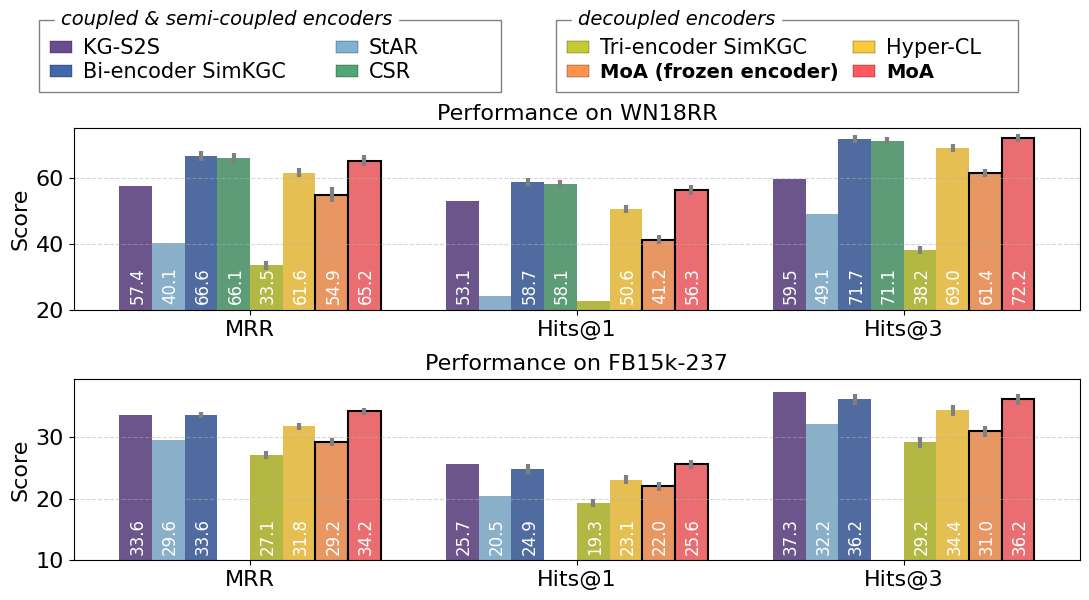

In [49]:
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(11, 6.0))
ylims_0 = (20, 75)
ylims_1 = (10, 39.5)

def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)

# First plot (top)
sns.barplot(data=df1_melted, x="Metric", y="Score", hue="Method", errorbar=None,
            order=metrics, hue_order=method_order, palette=custom_palette, ax=axes[0])
axes[0].set_title("Performance on WN18RR", fontsize=16)
axes[0].set_xlabel("")
axes[0].set_ylabel("Score", fontsize=16)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].set_ylim(ylims_0)
axes[0].tick_params(labelsize=16)
axes[0].legend_.remove()

rows = [row for _, row in df1_melted.iterrows()]
row_idx = 0
for container in list(axes[0].containers):
    for bar in container:
        row = rows[row_idx]
        try:
            height = bar.get_height()
            yerr = row['Error']
            x = bar.get_x() + bar.get_width() / 2
            if height > 30:
                axes[0].text(x + 0.005, ylims_0[0] + 1.6, f"{height:.1f}", ha='center', va='bottom', fontsize=12, color='white', rotation=90)
                axes[0].errorbar(x, height, yerr=yerr, color='gray', elinewidth=3)
            if 'MoA' in row['Method']:
                bar.set_edgecolor("black")
                bar.set_linewidth(1.5)
        except:
            print("Error in error bar calculation")
        row_idx += 1

# Second plot (bottom)
sns.barplot(data=df2_melted, x="Metric", y="Score", hue="Method", errorbar=None,
            hue_order=method_order, palette=custom_palette, ax=axes[1])
axes[1].set_title("Performance on FB15k-237", fontsize=16)
axes[1].set_xlabel("", fontsize=14)
axes[1].set_ylabel("Score", fontsize=16)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].set_ylim(ylims_1)
axes[1].tick_params(labelsize=16)
axes[1].legend_.remove()

rows = [row for _, row in df2_melted.iterrows()]
row_idx = 0
for container in list(axes[1].containers):
    for bar in container:
        row = rows[row_idx]
        try:
            height = bar.get_height()
            yerr = row['Error']
            x = bar.get_x() + bar.get_width() / 2
            if height > 18:
                axes[1].text(x + 0.005, ylims_1[0] + 0.8, f"{height:.1f}", ha='center', va='bottom', fontsize=12, color='white', rotation=90)
                axes[1].errorbar(x, height, yerr=yerr, color='gray', elinewidth=3)
            if 'MoA' in row['Method']:
                bar.set_edgecolor("black")
                bar.set_linewidth(1.5)
        except:
            print("Error in error bar calculation")
        row_idx += 1

# -----------------------
# Custom legend: two groups side-by-side, two rows each
# -----------------------
group_y_top = 0.94  # top of legend area
row_height = 0.04
icon_size = 0.02
text_offset_x = 0.03

# Coupled group
x_start_left = 0.05
row_items = 2
x_spacing = 0.26
fig.text(x_start_left + 0.01, group_y_top + 0.02, "coupled & semi-coupled encoders", fontsize=14, style='italic', va='bottom', backgroundcolor='white')

for idx, method in enumerate(coupled_methods):
    row = idx // row_items
    col = idx % row_items
    x = x_start_left + col * x_spacing
    y = group_y_top - row * row_height - 0.02
    # Color box
    fig.patches.append(Rectangle((x, y), icon_size, icon_size,
                                 transform=fig.transFigure, facecolor=custom_palette[method], edgecolor='black', linewidth=0.2))
    # Text
    fig.text(x + text_offset_x, y - 0.008, method, fontsize=15, va='bottom')

# Rectangle around coupled group
coupled_width = (min(row_items, len(coupled_methods)) * x_spacing)
coupled_height = (1 + (len(coupled_methods)-1)//row_items) * row_height
fig.patches.append(Rectangle((x_start_left - 0.01, group_y_top - coupled_height - 0.005),
                             coupled_width - 0.1, coupled_height + 0.04,
                             transform=fig.transFigure, facecolor='none', edgecolor='gray', linewidth=1))


# decoupled group
x_start_right = 0.52
row_items = 2 
x_spacing = 0.26
fig.text(x_start_right + 0.01, group_y_top + 0.02, "decoupled encoders", fontsize=14, style='italic', va='bottom', backgroundcolor='white')

for idx, method in enumerate(decoupled_methods):
    row = idx // row_items
    col = idx % row_items
    x = x_start_right + col * x_spacing
    y = group_y_top - row * row_height - 0.02
    fig.patches.append(Rectangle((x, y), icon_size, icon_size,
                                 transform=fig.transFigure, facecolor=custom_palette[method], edgecolor='black', linewidth=0.2))
    if 'MoA' in method:
        fig.text(x + text_offset_x, y - 0.008, method, fontsize=14, va='bottom', fontweight='bold')
    else:
        fig.text(x + text_offset_x, y - 0.008, method, fontsize=15, va='bottom')

# Rectangle around decoupled group
decoupled_width = (min(row_items, len(decoupled_methods)) * x_spacing)
decoupled_height = (1 + (len(decoupled_methods)-1)//row_items) * row_height
fig.patches.append(Rectangle((x_start_right - 0.01, group_y_top - decoupled_height - 0.005),
                             decoupled_width - 0.1, decoupled_height + 0.04,
                             transform=fig.transFigure, facecolor='none', edgecolor='gray', linewidth=1))

plt.tight_layout(rect=[0, 0, 1, 0.86])  # Make room for legend
fig.savefig("kgc_plot.pdf", format="pdf", bbox_inches="tight")

plt.show()